In [1]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
# Import tensorflow dependencies - Functional API
import tensorflow as tf
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall
# Import custom class and functions
from utils import L1Dist, cut_frame, preprocess_file, preprocess_numpy, verify
# Import file utils
import shutil

2024-09-06 17:08:08.209553: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-06 17:08:09.670874: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Reload model 
siamese_model = os.path.join('data', 'siamesemodelv2.keras')
siamese_model = tf.keras.models.load_model(siamese_model, custom_objects={'L1Dist': L1Dist})

2024-09-06 17:08:13.949842: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-06 17:08:14.299530: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-09-06 17:08:14.368308: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150994944 exceeds 10% of free system memory.
2024-09-06 17:08:14.471716: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150994944 exceeds 10

In [14]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_1 (L1Dist)  │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [3]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
APP_PATH = os.path.join('data', 'app')

In [16]:
# Make fresh app directory
shutil.rmtree(APP_PATH, ignore_errors=True)
os.makedirs(APP_PATH, exist_ok=True)

positive = os.listdir(POS_PATH)
random.shuffle(positive)

# Take this many random positive images
for img in positive[:35]:
    shutil.copy(
        os.path.join(POS_PATH, img),
        APP_PATH,
    )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

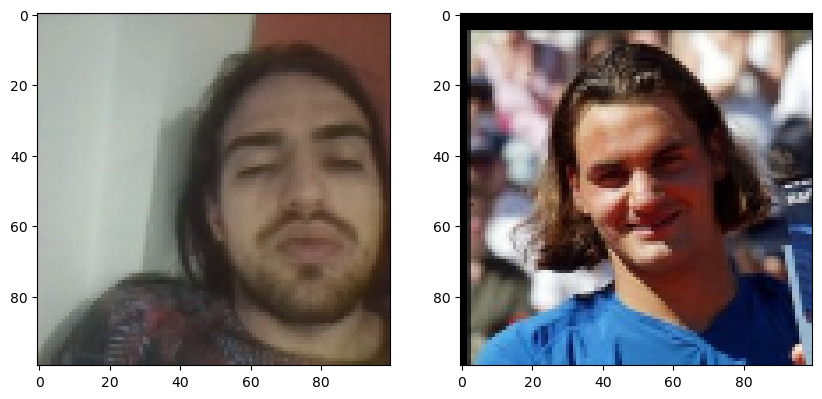

False


In [4]:
model_img = preprocess_file(os.path.join(APP_PATH, random.choice(os.listdir(APP_PATH))))
input_img = preprocess_file(os.path.join(NEG_PATH, random.choice(os.listdir(NEG_PATH))))
results, verified = verify(input_img, siamese_model, APP_PATH, 0.7, 0.6)

# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(model_img)

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(input_img)

# Renders cleanly
plt.show()
print(verified)

In [6]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = cut_frame(frame)

    cv2.imshow('Verification', frame)

    key = cv2.waitKey(1) & 0XFF
    match key:
        # Verification trigger on v
        case 118:
            #cv2.imwrite('input.jpg', frame)
            #input_img = preprocess_file('input.jpg')
            input_img = preprocess_numpy(frame)

            results, verified = verify(input_img, siamese_model, APP_PATH, 0.7 0.6)
            print(verified)
        # Break gracefully on q
        case 113: break

cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [7]:
# Percentage of images that identify at least 70%
np.sum(np.squeeze(results) > 0.7) / len(results) * 100

94.28571428571428

In [8]:
results

[array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.6797763]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.99279684]], dtype=float32),
 array([[0.99782217]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.9998843]], dtype=float32),
 array([[0.9990202]], dtype=float32),
 array([[0.99977523]], dtype=float32),
 array([[0.99754024]], dtype=float32),
 array([[0.9830968]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.53368264]], dtype=float32),
 array([[0.99999624]], dtype=float32),
 array([[0.9999999]], dtype=float32),
 array([[0.99999803]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.9999949]], dtype=float32),
 array([[0.99999994]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.99987924]], dtype=float32),
 array([[0.9999253]], dtype=float32),
 array([[1.